# Library

In [ ]:
# Import Files from kaggle
import zipfile
from google.colab import files
# ===================================
import warnings
warnings.filterwarnings('ignore')
# ===================================
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# ===================================
# Deep Learning Library
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.data import ConcatDataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay , precision_score, recall_score, f1_score, classification_report

# ==================================
# Image Library
from IPython.display import display
from PIL import Image, ImageDraw, ImageFont

# ====================================

In [ ]:
# Install Kaggle
! pip install Kaggle
# Upload Kaggle Json File
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# API Data From Kaggle
! kaggle datasets download murtozalikhon/brain-tumor-multimodal-image-ct-and-mri
print('\n\n')
# Zip File Data
!ls

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/murtozalikhon/brain-tumor-multimodal-image-ct-and-mri
License(s): CC-BY-NC-SA-4.0
 93% 336M/361M [00:00<00:00, 697MB/s]
100% 361M/361M [00:00<00:00, 644MB/s]



brain-tumor-multimodal-image-ct-and-mri.zip  kaggle.json  sample_data


In [ ]:
# Extract Files
zip_ref = zipfile.ZipFile('/content/brain-tumor-multimodal-image-ct-and-mri.zip')
zip_ref.extractall('files')
zip_ref.close()

# Data Exploration

In [ ]:
# CUDA
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

device

'cuda'

In [ ]:
# Load The Dataset , Load MRI
MRI_dataset = datasets.ImageFolder(
    root='/content/files/Dataset/Brain Tumor MRI images',
    transform=None
)

# Load CT
CT_dataset = datasets.ImageFolder(
    root='/content/files/Dataset/Brain Tumor CT scan Images',
    transform=None
)

combined_dataset = ConcatDataset([MRI_dataset, CT_dataset])

shapes = []

for d in combined_dataset.datasets:
    for path, _ in d.samples:
        img = Image.open(path)
        arr = np.array(img)
        shapes.append(arr.shape)   # (H, W, 3)

print("Total Images =", len(shapes))

unique_shapes = set(shapes)
print("Number Of Different Shapes =", len(unique_shapes))

min_shape = min(unique_shapes, key=lambda x: (x[0], x[1]))
print("Mini Image Shape =", min_shape)

max_shape = max(unique_shapes, key=lambda x: (x[0], x[1]))
print("Max Image Shape =", max_shape)

only_hw = [s[:2] for s in shapes]
avg_shape = np.mean(only_hw, axis=0).astype(int)
print("Average Image Shape (H, W) =", tuple(avg_shape))

Total Images = 9618
Number Of Different Shapes = 584
Mini Image Shape = (100, 100, 3)
Max Image Shape = (1446, 1375, 3)
Average Image Shape (H, W) = (np.int64(512), np.int64(510))


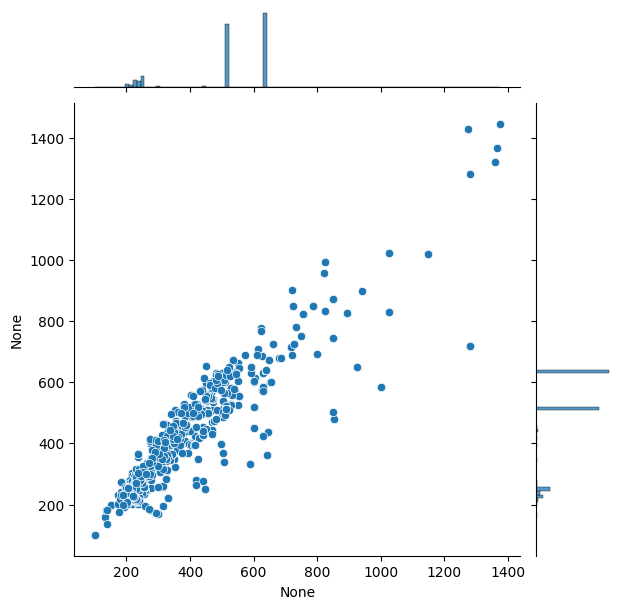

In [ ]:
shapes_array = np.array([s[:2] for s in shapes])

dim_train_height = shapes_array[:, 0]
dim_train_width = shapes_array[:, 1]

sns.jointplot(x=dim_train_width, y=dim_train_height)

plt.show()

In [ ]:
#Resizing images and turning them into tensors for matrix operations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [ ]:
# Load The Dataset , Load MRI
MRI_dataset = datasets.ImageFolder(
    root='/content/files/Dataset/Brain Tumor MRI images',
    transform=transform
)

# Load CT
CT_dataset = datasets.ImageFolder(
    root='/content/files/Dataset/Brain Tumor CT scan Images',
    transform=transform
)
combined_dataset = ConcatDataset([MRI_dataset, CT_dataset])

# Specify Ratio
MRI_train_size = int(0.8 * len(combined_dataset)) # 80 %
MRI_test_size = len(combined_dataset) - MRI_train_size

# Specify Image
MRI_train_dataset, MRI_test_dataset = random_split(combined_dataset, [MRI_train_size, MRI_test_size])

MRI_train_loader = DataLoader(MRI_train_dataset, batch_size=32, shuffle=True)
MRI_test_loader = DataLoader(MRI_test_dataset, batch_size=32, shuffle=True)

print("MRI Training set size:", len(MRI_train_dataset))
print("MRI Testing set size:", len(MRI_test_dataset))

MRI Training set size: 7694
MRI Testing set size: 1924


In [ ]:
# print("MRI Classes:", combined_dataset.classes)
all_classes = list(set(MRI_dataset.classes + CT_dataset.classes))
print("All Classes:", all_classes)

All Classes: ['Tumor', 'Healthy']


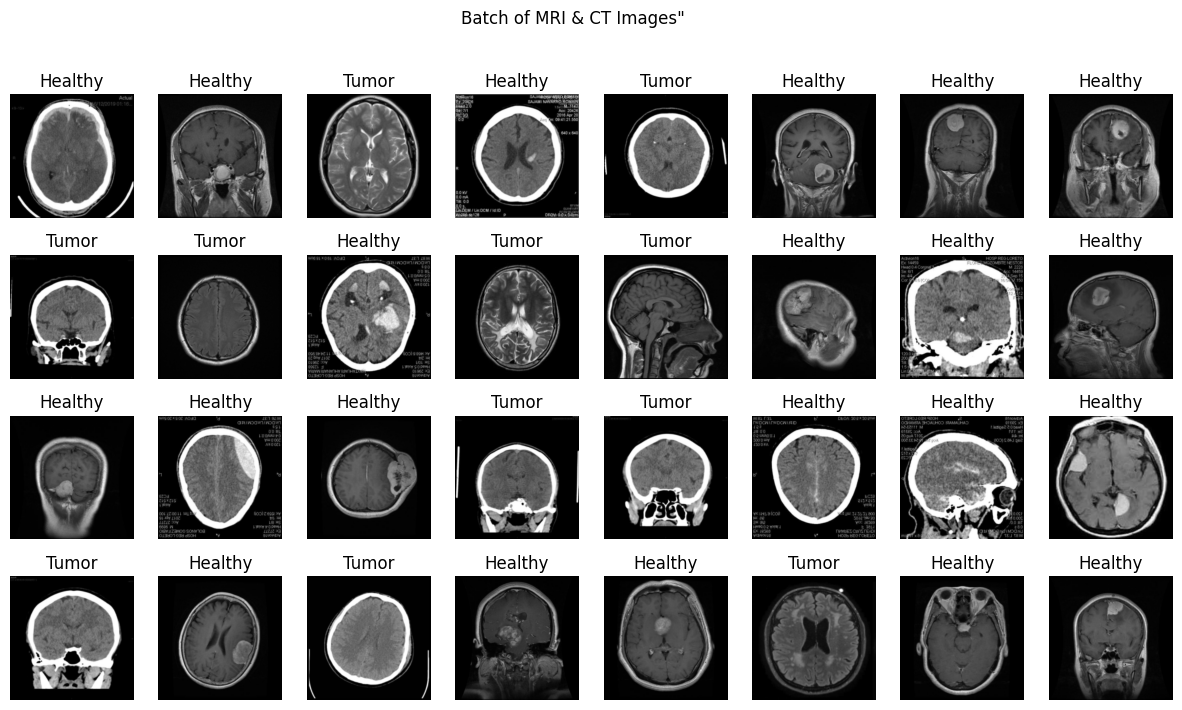

In [ ]:
images, labels = next(iter(MRI_train_loader))
fig, axes = plt.subplots(4, 8, figsize=(15, 8))
fig.suptitle('Batch of MRI & CT Images"')

for i, ax in enumerate(axes.flatten()):
    if i < len(images):
        img = images[i].permute(1, 2, 0)  # Convert tensor image for plotting
        ax.imshow(img)
        ax.set_title(all_classes[labels[i].item()])
        ax.axis('off')
plt.show()

# ================================
# DL Model [CNN]

In [ ]:
mri_model = nn.Sequential(
    # 1) - First convolutional layer
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),  # Output: 224x224x32
    nn.ReLU(),

    # 2) - Second convolutional layer
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),  # Output: 224x224x64
    nn.ReLU(),

    #  First max pooling layer
    nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 112x112x64

    # 3) - Third convolutional layer
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),  # Output: 112x112x128
    nn.ReLU(),

    # 4) - Fourth convolutional layer
    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),  # Output: 112x112x256
    nn.ReLU(),

    # Second max pooling layer
    nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 56x56x256

    # 5) - Fifth convolutional layer
    nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),  # Output: 56x56x512
    nn.ReLU(),

    # 6) - Sixth convolutional layer
    nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1),  # Output: 56x56x1024
    nn.ReLU(),

    # Third max pooling layer
    nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 28x28x1024

    # Fourth max pooling layer
    nn.MaxPool2d(kernel_size=4, stride=4),  # Output: 7x7x1024

    # Flatten layer
    nn.Flatten(),  # Output: 7x7x1024 = 50176

    # Fully connected layer
    nn.Linear(in_features=7 * 7 * 1024, out_features=256),  # Reduce dimensionality
    nn.ReLU(),
    nn.Dropout(0.5),  # Dropout to prevent overfitting

    # Final output layer
    nn.Linear(in_features=256, out_features=2)  # Output: 2 (num_classes)
)

In [ ]:
mri_model

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU()
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU()
  (12): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (16): Flatten(start_dim=1, end_dim=-1)
  (17): Linear(in_features=50176, out_features=256, bias=True)
  (18): ReLU()
  (19)

In [ ]:
from torchsummary import summary
mri_model = mri_model.to(device)
summary(mri_model, input_size=(3, 224, 224) , device=str(device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
              ReLU-2         [-1, 32, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          18,496
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 256, 112, 112]         295,168
              ReLU-9        [-1, 256, 112, 112]               0
        MaxPool2d-10          [-1, 256, 56, 56]               0
           Conv2d-11          [-1, 512, 56, 56]       1,180,160
             ReLU-12          [-1, 512, 56, 56]               0
           Conv2d-13         [-1, 1024, 56, 56]       4,719,616
             ReLU-14         [-1, 1024,

In [ ]:
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(mri_model.parameters(),lr=0.001)
mri_model=mri_model.to(device)

In [ ]:
from tqdm import tqdm

num_epochs = 10

for epoch in range(num_epochs):
    # =========================
    # Training
    # =========================
    mri_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in tqdm(MRI_train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = mri_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # train accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(MRI_train_loader)
    train_acc = 100 * correct_train / total_train

    # =========================
    # Validation / Testing
    # =========================
    mri_all_labels = []
    mri_all_predictions = []

    mri_model.eval()
    correct_val = 0
    total_val = 0

    with torch.inference_mode():
        for images, labels in tqdm(MRI_test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Valid]"):
            images, labels = images.to(device), labels.to(device)
            outputs = mri_model(images)
            _, predicted = torch.max(outputs, 1)

            mri_all_labels.extend(labels.cpu().numpy())
            mri_all_predictions.extend(predicted.cpu().numpy())

            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_acc = 100 * correct_val / total_val

    # Convert lists to numpy arrays
    mri_all_labels = np.array(mri_all_labels)
    mri_all_predictions = np.array(mri_all_predictions)

    # Extra Metrics
    precision = precision_score(mri_all_labels, mri_all_predictions, average='weighted')
    recall = recall_score(mri_all_labels, mri_all_predictions, average='weighted')
    f1 = f1_score(mri_all_labels, mri_all_predictions, average='weighted')
    cm = confusion_matrix(mri_all_labels, mri_all_predictions)

    # =========================
    # Print Results
    # =========================
    print("================================================================================================================")
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, "
          f"Train Acc: {train_acc:.2f}%, "
          f"Valid Acc: {val_acc:.2f}%, "
          f"Precision: {precision:.4f}, "
          f"Recall: {recall:.4f}, "
          f"F1-score: {f1:.4f}")

    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", classification_report(mri_all_labels, mri_all_predictions))


Epoch 1/10 [Valid]: 100%|██████████| 61/61 [00:20<00:00,  3.03it/s]


Epoch [1/10], Train Loss: 0.6902, Train Acc: 55.82%, Valid Acc: 71.88%, Precision: 0.7177, Recall: 0.7188, F1-score: 0.7162
Confusion Matrix:
 [[528 321]
 [220 855]]
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.62      0.66       849
           1       0.73      0.80      0.76      1075

    accuracy                           0.72      1924
   macro avg       0.72      0.71      0.71      1924
weighted avg       0.72      0.72      0.72      1924



Epoch 2/10 [Valid]: 100%|██████████| 61/61 [00:19<00:00,  3.05it/s]


Epoch [2/10], Train Loss: 0.4341, Train Acc: 79.75%, Valid Acc: 89.19%, Precision: 0.8918, Recall: 0.8919, F1-score: 0.8918
Confusion Matrix:
 [[737 112]
 [ 96 979]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.87      0.88       849
           1       0.90      0.91      0.90      1075

    accuracy                           0.89      1924
   macro avg       0.89      0.89      0.89      1924
weighted avg       0.89      0.89      0.89      1924



Epoch 3/10 [Valid]: 100%|██████████| 61/61 [00:20<00:00,  3.05it/s]


Epoch [3/10], Train Loss: 0.2759, Train Acc: 87.87%, Valid Acc: 91.11%, Precision: 0.9164, Recall: 0.9111, F1-score: 0.9114
Confusion Matrix:
 [[812  37]
 [134 941]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.96      0.90       849
           1       0.96      0.88      0.92      1075

    accuracy                           0.91      1924
   macro avg       0.91      0.92      0.91      1924
weighted avg       0.92      0.91      0.91      1924



Epoch 4/10 [Valid]: 100%|██████████| 61/61 [00:19<00:00,  3.06it/s]


Epoch [4/10], Train Loss: 0.2271, Train Acc: 90.21%, Valid Acc: 91.42%, Precision: 0.9154, Recall: 0.9142, F1-score: 0.9144
Confusion Matrix:
 [[787  62]
 [103 972]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.93      0.91       849
           1       0.94      0.90      0.92      1075

    accuracy                           0.91      1924
   macro avg       0.91      0.92      0.91      1924
weighted avg       0.92      0.91      0.91      1924



Epoch 5/10 [Valid]: 100%|██████████| 61/61 [00:20<00:00,  3.02it/s]


Epoch [5/10], Train Loss: 0.1884, Train Acc: 91.92%, Valid Acc: 92.83%, Precision: 0.9291, Recall: 0.9283, F1-score: 0.9280
Confusion Matrix:
 [[ 754   95]
 [  43 1032]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.89      0.92       849
           1       0.92      0.96      0.94      1075

    accuracy                           0.93      1924
   macro avg       0.93      0.92      0.93      1924
weighted avg       0.93      0.93      0.93      1924



Epoch 6/10 [Valid]: 100%|██████████| 61/61 [00:19<00:00,  3.07it/s]


Epoch [6/10], Train Loss: 0.1631, Train Acc: 92.71%, Valid Acc: 93.56%, Precision: 0.9371, Recall: 0.9356, F1-score: 0.9357
Confusion Matrix:
 [[812  37]
 [ 87 988]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.96      0.93       849
           1       0.96      0.92      0.94      1075

    accuracy                           0.94      1924
   macro avg       0.93      0.94      0.94      1924
weighted avg       0.94      0.94      0.94      1924



Epoch 7/10 [Valid]: 100%|██████████| 61/61 [00:19<00:00,  3.06it/s]


Epoch [7/10], Train Loss: 0.1398, Train Acc: 93.80%, Valid Acc: 94.23%, Precision: 0.9423, Recall: 0.9423, F1-score: 0.9423
Confusion Matrix:
 [[ 787   62]
 [  49 1026]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.93      0.93       849
           1       0.94      0.95      0.95      1075

    accuracy                           0.94      1924
   macro avg       0.94      0.94      0.94      1924
weighted avg       0.94      0.94      0.94      1924



Epoch 8/10 [Valid]: 100%|██████████| 61/61 [00:19<00:00,  3.10it/s]


Epoch [8/10], Train Loss: 0.1222, Train Acc: 94.48%, Valid Acc: 95.01%, Precision: 0.9503, Recall: 0.9501, F1-score: 0.9501
Confusion Matrix:
 [[ 809   40]
 [  56 1019]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.95      0.94       849
           1       0.96      0.95      0.96      1075

    accuracy                           0.95      1924
   macro avg       0.95      0.95      0.95      1924
weighted avg       0.95      0.95      0.95      1924



Epoch 9/10 [Valid]: 100%|██████████| 61/61 [00:19<00:00,  3.12it/s]


Epoch [9/10], Train Loss: 0.1174, Train Acc: 94.81%, Valid Acc: 95.37%, Precision: 0.9537, Recall: 0.9537, F1-score: 0.9537
Confusion Matrix:
 [[ 803   46]
 [  43 1032]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95       849
           1       0.96      0.96      0.96      1075

    accuracy                           0.95      1924
   macro avg       0.95      0.95      0.95      1924
weighted avg       0.95      0.95      0.95      1924



Epoch 10/10 [Valid]: 100%|██████████| 61/61 [00:19<00:00,  3.13it/s]

Epoch [10/10], Train Loss: 0.1049, Train Acc: 95.72%, Valid Acc: 93.04%, Precision: 0.9347, Recall: 0.9304, F1-score: 0.9306
Confusion Matrix:
 [[826  23]
 [111 964]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.92       849
           1       0.98      0.90      0.94      1075

    accuracy                           0.93      1924
   macro avg       0.93      0.93      0.93      1924
weighted avg       0.93      0.93      0.93      1924



In [ ]:
# #Train and Test Loop for PyTorch

# from tqdm import tqdm
# num_epochs = 10

# for epoch in range(num_epochs):
#     mri_model.train()
#     running_loss = 0.0
#     for images, labels in tqdm(MRI_train_loader):
#         images, labels = images.to(device), labels.to(device)

#         optimizer.zero_grad()
#         outputs = mri_model(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()

#     # store labels & predictions
#     mri_all_labels = []
#     mri_all_predictions = []

#     mri_model.eval()
#     correct = 0
#     total = 0

#     with torch.inference_mode():
#         for images, labels in tqdm(MRI_test_loader):
#             images, labels = images.to(device), labels.to(device)
#             outputs = mri_model(images)
#             _, predicted = torch.max(outputs, 1)

#             mri_all_labels.extend(labels.cpu().numpy())
#             mri_all_predictions.extend(predicted.cpu().numpy())

#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#     # Convert lists to numpy arrays
#     mri_all_labels = np.array(mri_all_labels)
#     mri_all_predictions = np.array(mri_all_predictions)

#     # Extra Metrics
#     precision = precision_score(mri_all_labels, mri_all_predictions, average='weighted')
#     recall = recall_score(mri_all_labels, mri_all_predictions, average='weighted')
#     f1 = f1_score(mri_all_labels, mri_all_predictions, average='weighted')
#     cm = confusion_matrix(mri_all_labels, mri_all_predictions)

#     print("================================================================================================================")
#     print(f"Epoch [{epoch+1}/{num_epochs}], "
#           f"Loss: {running_loss/len(MRI_train_loader):.4f}, "
#           f"Accuracy: {100 * correct / total:.2f}%, "
#           f"Precision: {precision:.4f}, "
#           f"Recall: {recall:.4f}, "
#           f"F1-score: {f1:.4f}")

#     print("Confusion Matrix:\n", cm)
#     print("Classification Report:\n", classification_report(mri_all_labels, mri_all_predictions))

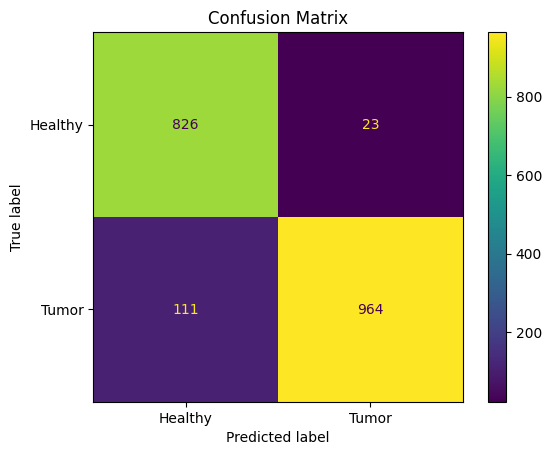

In [ ]:
cm = confusion_matrix(mri_all_labels, mri_all_predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Healthy", "Tumor"])
disp.plot()
plt.title("Confusion Matrix")
plt.show()

In [ ]:
torch.save(mri_model, 'mri_model.pth')  # Save the model
mri_saved = torch.load('mri_model.pth', weights_only=False)  # Load the model
# mri_saved = mri_saved.to(device)

In [ ]:
from google.colab import files

files.download('mri_model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

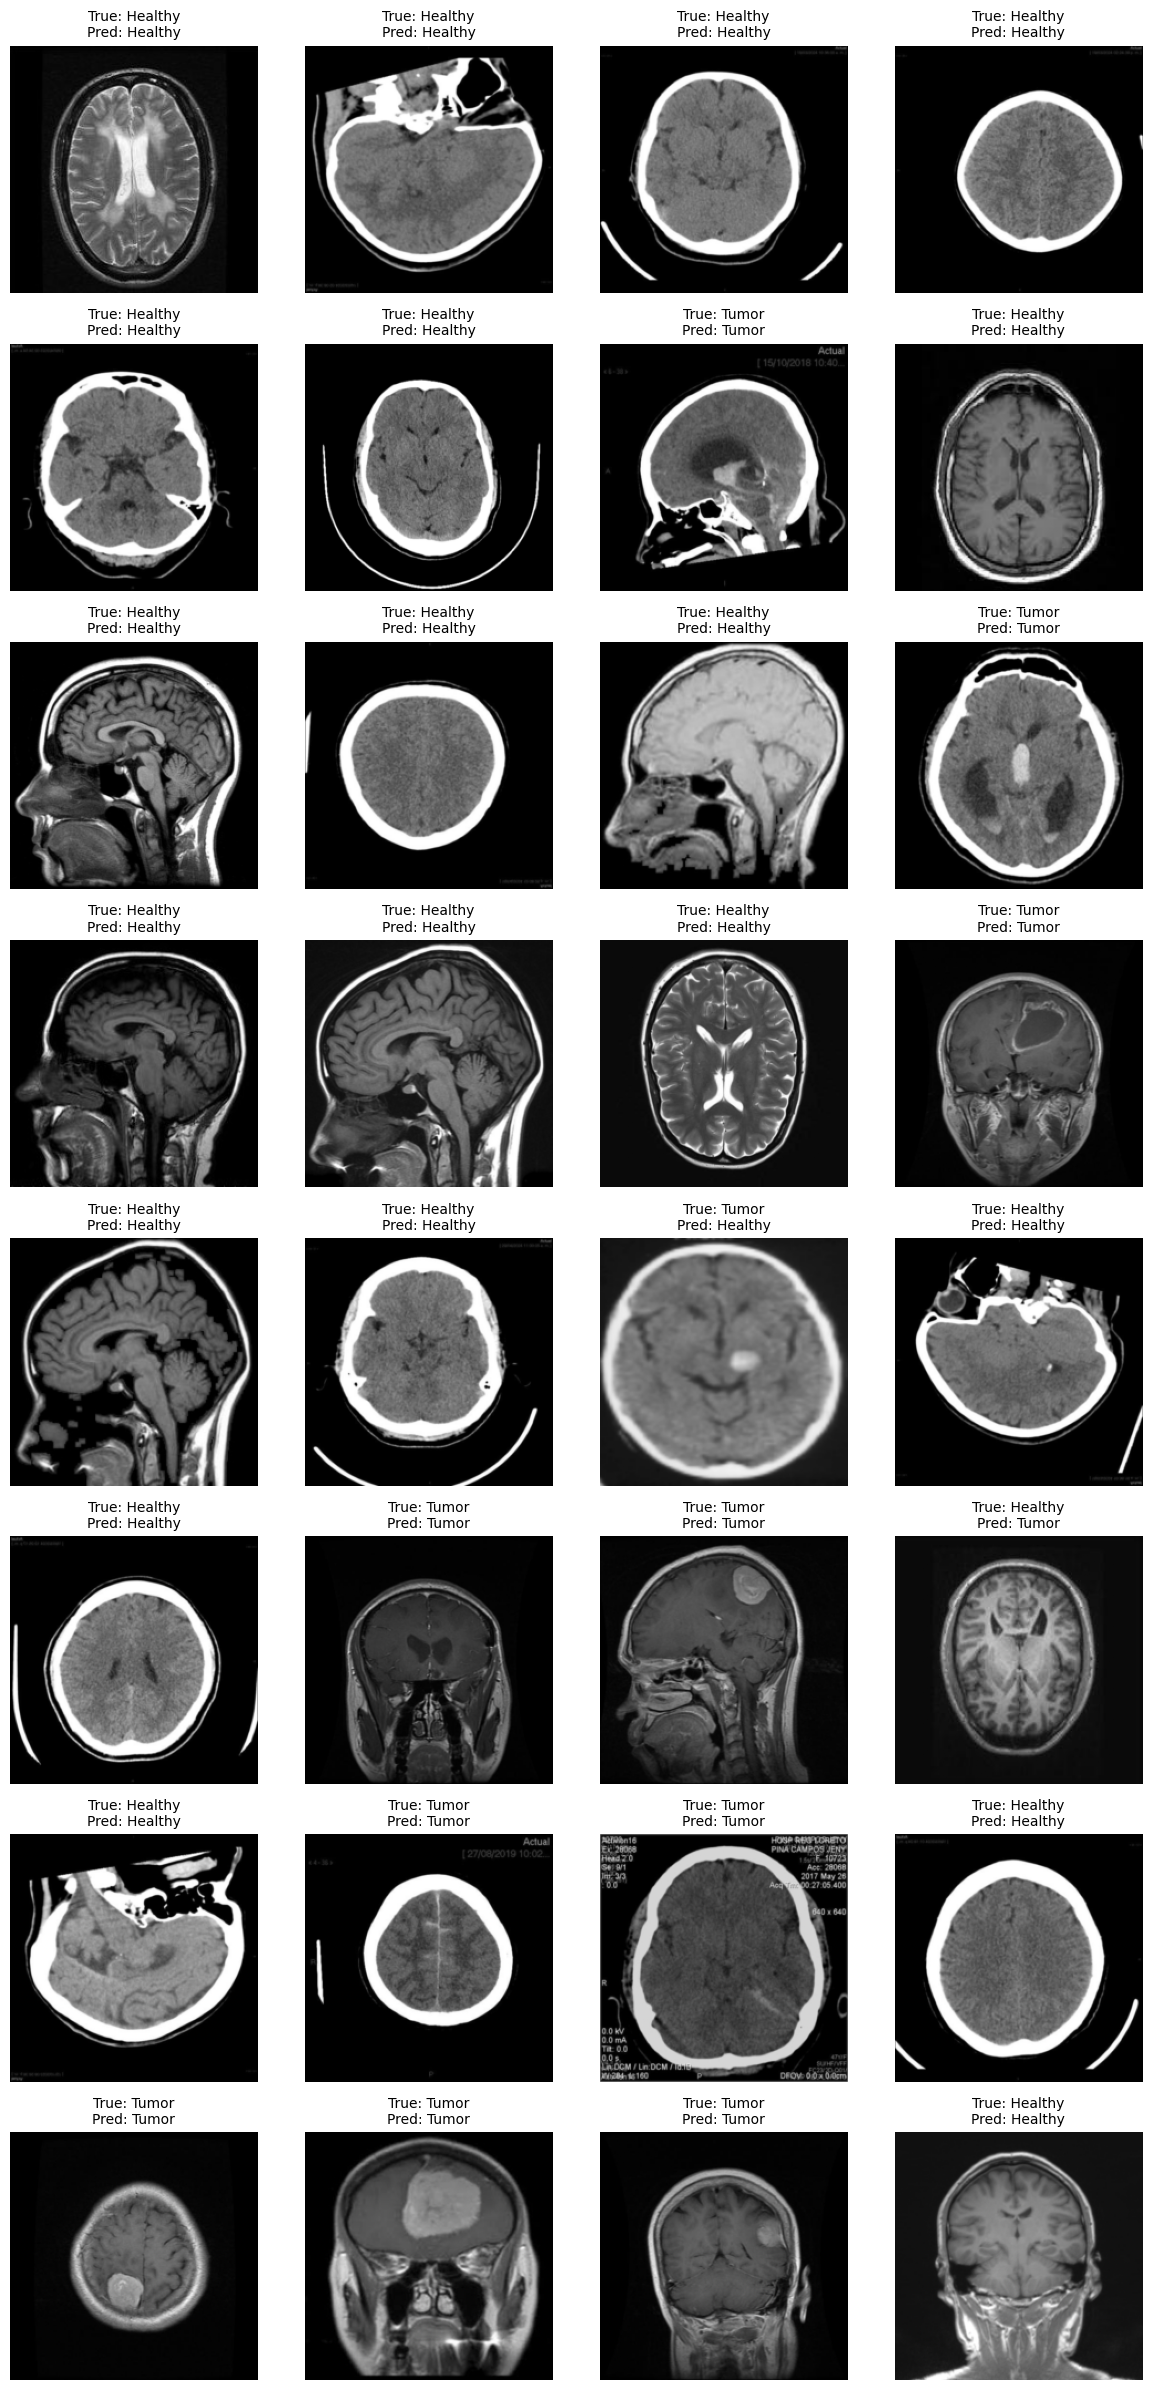

In [ ]:
#Predicting some labels

mri_images, mri_labels = next(iter(MRI_test_loader))

mri_images, mri_labels = mri_images.to(device), mri_labels.to(device)

mri_saved.eval()

logits = mri_saved(mri_images)
_, predicted_indices = torch.max(logits, 1)

true_labels = [all_classes[label.item()] for label in mri_labels]
predicted_labels = [all_classes[pred.item()] for pred in predicted_indices]

batch_size = len(mri_images)
cols = 4
rows = (batch_size + cols - 1) // cols

plt.figure(figsize=(12, rows * 3))

for idx in range(batch_size):
    plt.subplot(rows, cols, idx + 1)
    img = mri_images[idx].cpu().permute(1, 2, 0).numpy()
    true_label = true_labels[idx]
    predicted_label = predicted_labels[idx]
    plt.imshow(img)
    plt.title(f"True: {true_label}\nPred: {predicted_label}", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

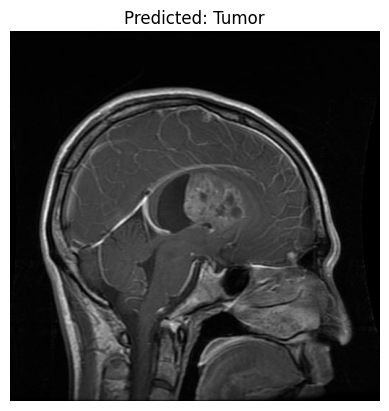

In [ ]:
from PIL import Image
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

img_path = "/content/glioma (1).jpg"
img = Image.open(img_path).convert("RGB")

input_img = transform(img).unsqueeze(0).to(device)  # (1, C, H, W)

mri_saved.eval()
with torch.inference_mode():
    logits = mri_saved(input_img)
    _, predicted_idx = torch.max(logits, 1)

predicted_label = all_classes[predicted_idx.item()]

plt.imshow(img)
plt.title(f"Predicted: {predicted_label}")
plt.axis("off")
plt.show()
